In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from calendar import month_abbr
from calendar import month_name
import scipy.stats as stats
import math
import geopandas as gp
import pandas as pd

In [2]:
from dask.distributed import Client  
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43771,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:46703,Total threads: 4
Dashboard: /proxy/39161/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:40665,


# Reviewer 1

## Major comment 1: Why rainfall increase in year 3 but not in year 2?

SST anomalies composited for JJA, SON, DJF, MAM over the tropical Pacific and around Australia; for year 1, 2, and 3.

In [3]:
# ERSSTv5 original gridded sst data
ds_obs = xr.open_dataset('/g/data/w97/ah3693-2/CLEX_summer/sst.mnmean.nc')
sst_aus_pac = ds_obs.where((ds_obs.lat<=40) & (ds_obs.lat>=-60) & (ds_obs.lon>=35) & (ds_obs.lon<=295), drop = True)

0.3.0


In [4]:
# identified El Nino and La Nina event and years
fst_elnino_f = [1902, 1904, 1911, 1913, 1918, 1923, 1925, 1930, 1939, 1951, 1953, 1957, 1963, 1965, 1968, 1972, 1976, 1979, 1982, 1986, 1991, 1994, 1997, 2002, 2004, 2006, 2009, 2014, 2018]
fst_elnino_s = [1905, 1914, 1919, 1940, 1958, 1969, 1977, 1987, 2015]
fst_lanina_f = [1903, 1906, 1908, 1915, 1922, 1924, 1933, 1938, 1942, 1949, 1954, 1964, 1970, 1973, 1983, 1988, 1995, 1998, 2005, 2007, 2010, 2016, 2020]
fst_lanina_s = [1909, 1916, 1955, 1971, 1974, 1984, 1999, 2008, 2011, 2017, 2021]
fst_lanina_t = [1910, 1917, 1975, 2000, 2022]

elnino_year = np.array(fst_elnino_f + fst_elnino_s + [1941])
lanina_year = np.array(fst_lanina_f + fst_lanina_s + fst_lanina_t)

In [5]:
# sst anomaly and detrend using ONI method
def anom(df,time_period,base_year):
    gb = df.sel(time=time_period).groupby('time.month')
    gb_base = df.sel(time=base_year).groupby('time.month')
    df_anom = gb - gb_base.mean(dim='time')
    return df_anom

anomalies = []

# 1900-2010
for year in range(1896,2011,5):
    time_period = slice(str(year),str(year+4))
    base_year = slice(str(year-15),str(year+14))
    
    anomaly = anom(sst_aus_pac,time_period,base_year)
    anomalies.append(anomaly)

# 2011-2023
anomaly = anom(sst_aus_pac, slice(str(2011),str(2023)), slice(str(1991),str(2020)))
anomalies.append(anomaly)

# Concatenate the anomalies along the time dimension
all_anomalies = xr.concat(anomalies, dim='time')

In [6]:
# seasonal composites
# jja = 0, son = 1, djf = 2, mam = 3
def seasonal_composites(climate_parameter,ENSO_year):

    seasonal_mean = climate_parameter.resample(time='QS-DEC').mean()
    
    parameter_year1 = seasonal_mean.sel(time=seasonal_mean.time.dt.year.isin([ENSO_year]))
    parameter_year2 = seasonal_mean.sel(time=seasonal_mean.time.dt.year.isin([np.asarray(ENSO_year) + 1]))
    
    jja = parameter_year1.sel(time=parameter_year1.time.dt.month.isin([6])).mean(dim='time')
    son = parameter_year1.sel(time=parameter_year1.time.dt.month.isin([9])).mean(dim='time')
    djf = parameter_year1.sel(time=parameter_year1.time.dt.month.isin([12])).mean(dim='time')
    mam = parameter_year2.sel(time=parameter_year2.time.dt.month.isin([3])).mean(dim='time')
    
    return xr.concat([jja, son, djf, mam],dim='season')

In [7]:
sst_elnino_year1, sst_elnino_year2 = [seasonal_composites(all_anomalies, elnino_fst) for elnino_fst in [fst_elnino_f, fst_elnino_s]]
sst_lanina_year1, sst_lanina_year2, sst_lanina_year3 = [seasonal_composites(all_anomalies, elnino_fst) for elnino_fst in [fst_lanina_f, fst_lanina_s, fst_lanina_t]]

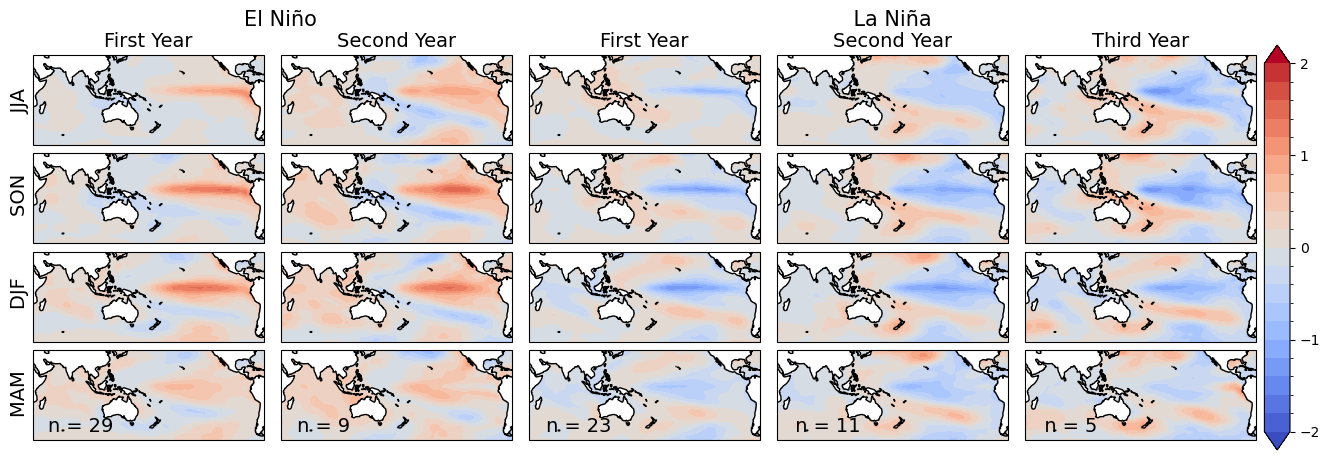

In [8]:
fig, axes = plt.subplots(4,5, figsize=(16, 5),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

title = ['First Year','Second Year','First Year','Second Year','Third Year']

for i, ENSO_fst in enumerate([sst_elnino_year1, sst_elnino_year2, sst_lanina_year1, sst_lanina_year2, sst_lanina_year3]):    
    for j in range(4):
        ax=axes[j,i]
        p = ENSO_fst.sst.isel(season=j).plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm',levels=np.linspace(-2,2,21),extend='both',add_colorbar=False)
        
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.coastlines()      

for i in range(5):
    axes[0,i].set_title(title[i],fontsize=14)

cax = plt.axes([0.9, 0.09, 0.016, 0.81]) #[left, bottom, width, height]
plt.colorbar(p,cax=cax,orientation='vertical')
cax.set_yticks(np.linspace(-2,2,5))

plt.text(-49,-1.8,'MAM          DJF          SON          JJA',rotation=90,fontsize=14)
plt.text(-47.5,-40,'n = 29                              n = 9                                n = 23                              n = 11                              n = 5',fontsize=14)

plt.subplots_adjust(wspace=0,hspace=0.1)
plt.suptitle('El Niño                                                                                 La Niña',x=0.477,y=0.97,fontsize=15)

plt.show()

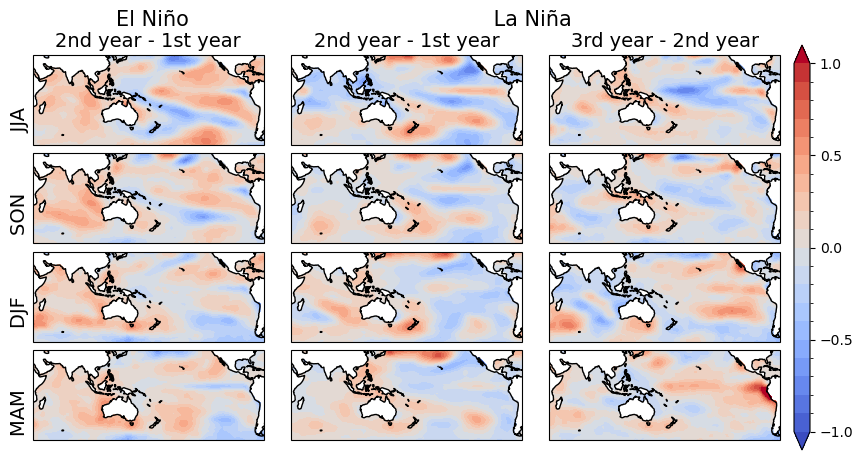

In [9]:
# Difference map
fig, axes = plt.subplots(4,3, figsize=(10, 5),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

title = ['2nd year - 1st year','2nd year - 1st year','3rd year - 2nd year']

for i, ENSO_fst in enumerate([sst_elnino_year2 - sst_elnino_year1, sst_lanina_year2 - sst_lanina_year1, sst_lanina_year3 - sst_lanina_year2]):    
    for j in range(4):
        ax=axes[j,i]
        p = ENSO_fst.sst.isel(season=j).plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm',levels=np.linspace(-1,1,21),extend='both',add_colorbar=False)
        
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.coastlines()      

for i in range(3):
    axes[0,i].set_title(title[i],fontsize=14)

cax = plt.axes([0.9, 0.09, 0.016, 0.81]) #[left, bottom, width, height]
plt.colorbar(p,cax=cax,orientation='vertical')
cax.set_yticks(np.linspace(-1,1,5))

plt.text(-49,-1.8,'MAM          DJF          SON          JJA',rotation=90,fontsize=14)

plt.subplots_adjust(wspace=0,hspace=0.1)
plt.suptitle('El Niño                                              La Niña',x=0.45,y=0.97,fontsize=15)

plt.show()

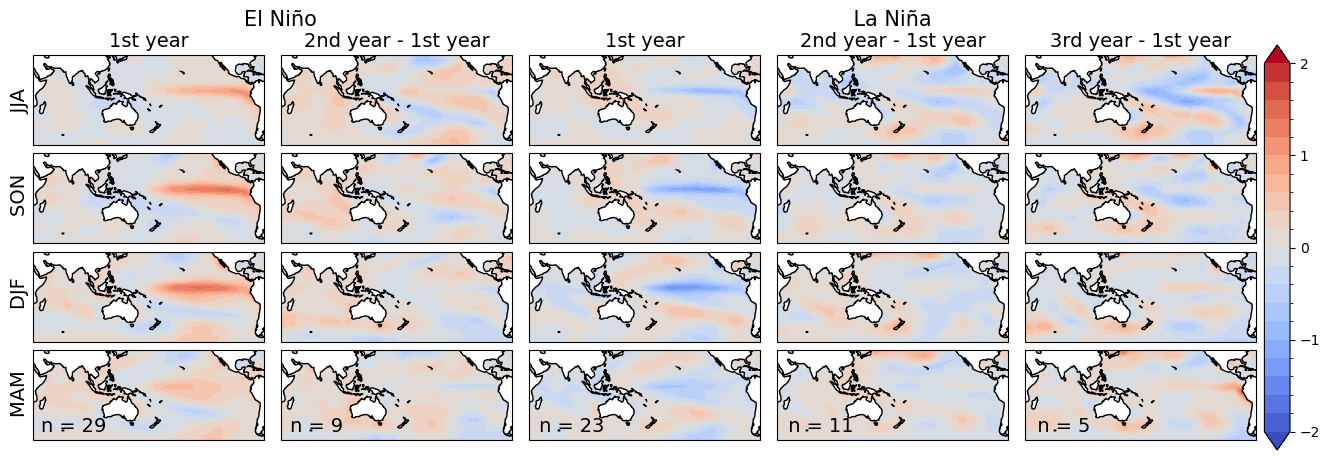

In [10]:
fig, axes = plt.subplots(4,5, figsize=(16, 5),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

title = ['1st year','2nd year - 1st year','1st year','2nd year - 1st year','3rd year - 1st year']

for i, ENSO_fst in enumerate([sst_elnino_year1, sst_elnino_year2 - sst_elnino_year1, sst_lanina_year1, sst_lanina_year2 - sst_lanina_year1, sst_lanina_year3 - sst_lanina_year1]):    
    for j in range(4):
        ax=axes[j,i]
        p = ENSO_fst.sst.isel(season=j).plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm',levels=np.linspace(-2,2,21),extend='both',add_colorbar=False)
        
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.coastlines()      

for i in range(5):
    axes[0,i].set_title(title[i],fontsize=14)

cax = plt.axes([0.9, 0.09, 0.016, 0.81]) #[left, bottom, width, height]
plt.colorbar(p,cax=cax,orientation='vertical')
cax.set_yticks(np.linspace(-2,2,5))

plt.text(-49,-1.8,'MAM          DJF          SON          JJA',rotation=90,fontsize=14)
plt.text(-47.8,-40,'n = 29                              n = 9                                n = 23                              n = 11                              n = 5',fontsize=14)

plt.subplots_adjust(wspace=0,hspace=0.1)
plt.suptitle('El Niño                                                                                 La Niña',x=0.477,y=0.97,fontsize=15)

plt.show()

## Major comment 2: Mechanism? Soil Moisture

Soil moisture autocorrelation analysis averaged over eastern Australia.

In [11]:
from statsmodels.graphics import tsaplots

In [12]:
# ERSSTv5 original gridded sst data
ENSO_corr_son = (xr.open_dataset('/g/data/w97/ah3693-2/CLEX_summer/ENSO_corr.nc')).sel(lat=slice(-44,-10)).sel(lon=slice(112,154))
dsoil = xr.open_dataset('/g/data/w97/ah3693-2/CLEX_summer/sm_1911_2023.nc')
dsoil = dsoil.rename({'longitude': 'lon','latitude': 'lat'})
dsoil = dsoil.sortby(dsoil.coords['lat'][::-1])
soil_e_aus_mean = dsoil.sm.where(ENSO_corr_son<-0.4).where(dsoil.lon>=138).where(dsoil.lat>=-39).mean(dim=['lat','lon'])
soil_e_aus_mean = soil_e_aus_mean.rename({'r': 'sm'})
soil_e_aus_mean_rolling3 = soil_e_aus_mean.sm.rolling(time=3, center = True).mean().dropna(dim = 'time')
soil_e_aus_mean_rolling5 = soil_e_aus_mean.sm.rolling(time=5, center = True).mean().dropna(dim = 'time')

In [13]:
dsoil

<xarray.Dataset>
Dimensions:      (time: 1350, lat: 681, lon: 841, nv: 2)
Coordinates:
  * time         (time) datetime64[ns] 1911-01-31 1911-02-28 ... 2023-06-30
  * lat          (lat) float64 -44.0 -43.95 -43.9 -43.85 ... -10.1 -10.05 -10.0
  * lon          (lon) float64 112.0 112.0 112.1 112.2 ... 153.9 153.9 154.0
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) int32 ...
    sm           (time, lat, lon) float32 ...
Attributes:
    var_name:       sm
    url:            http://www.bom.gov.au/water/landscape
    date_modified:  2018-10-09T03:41:12
    summary:        Data produced by Bureau of Meteorology Australian Water R...
    institution:    Bureau of Meteorology
    source:         AWRA-L-v5)
    title:          Australian Landscape Water Balance AWRA-L Model Version 5
    email:          awrams@bom.gov.au
    Conventions:    CF-1.6, ACDD-1.3
    date_created:   2018-10-09T03:41:12

In [14]:
soil_n_aus_mean = dsoil.sm.where(dsoil.lat>=-20).mean(dim=['lat','lon'])
soil_n_aus_mean_rolling3 = soil_n_aus_mean.rolling(time=3, center = True).mean().dropna(dim = 'time')
soil_n_aus_mean_rolling5 = soil_n_aus_mean.rolling(time=5, center = True).mean().dropna(dim = 'time')

In [15]:
def soil_moist_monthly(lanina_year):
    all_year = []
    for year in lanina_year:
        one_year = soil_e_aus_mean_rolling3.sel(time = slice(str(year)+'-07', str(year+1)+'-06'))
        all_year.append(one_year)
    
    all_year_xr = xr.concat(all_year, dim = 'time')
    lanina_soil = all_year_xr.groupby('time.month').mean(dim='time')
    # lanina_soil = lanina_soil.sortby(((lanina_soil.coords['month'] - 1 + 6) % 12) + 1)
    return lanina_soil

In [16]:
lanina_soil_f = soil_moist_monthly(fst_lanina_f)
lanina_soil_s = soil_moist_monthly(fst_lanina_s)
lanina_soil_t = soil_moist_monthly(fst_lanina_t)

all_lanina = fst_lanina_f + fst_lanina_s + fst_lanina_t
lanina_soil_all = soil_moist_monthly(all_lanina)

allyear = np.arange(1911,2024)
lanina_soil_climatology = soil_moist_monthly(allyear)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


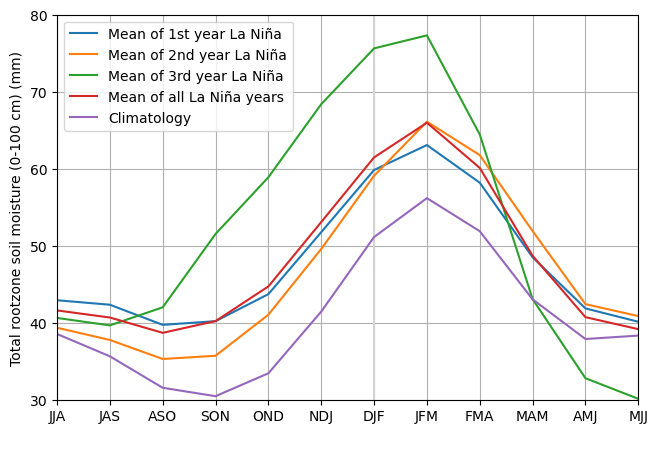

In [17]:
plt.figure(figsize=(7.5,5))
plt.axvline(7,color = 'lightgrey')

lanina_soil_f.roll(month=6).plot(label='Mean of 1st year La Niña')
lanina_soil_s.roll(month=6).plot(label='Mean of 2nd year La Niña')
lanina_soil_t.roll(month=6).plot(label='Mean of 3rd year La Niña')
lanina_soil_all.roll(month=6).plot(label='Mean of all La Niña years')
lanina_soil_climatology.roll(month=6).plot(label='Climatology')


plt.xticks(range(1, 13), ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ'])
plt.xlabel(' ')
plt.ylabel('Total rootzone soil moisture (0-100 cm) (mm)')
plt.xlim((1,12))
plt.ylim((30,80))
plt.legend()
plt.grid()

plt.savefig('/home/156/ah3693/CLEX_summer/FigR_Soil_moisture_mean_evolution.eps',bbox_inches="tight", format='eps',dpi=700)

plt.show()

In [18]:
# Soil moisture anomaly
gb = dsoil.groupby('time.month')
soil_anom = gb - gb.mean(dim='time')

In [19]:
def ENSO_allmonth(anomaly, ENSO_year):
    
    precip_year1 = anomaly.sel(time=anomaly.time.dt.year.isin([ENSO_year]))
    precip_year2 = anomaly.sel(time=anomaly.time.dt.year.isin([np.asarray(ENSO_year) + 1]))
    precip_jun_to_dec = [precip_year1.sel(time=precip_year1.time.month.isin([month])) for month in range(6,13)]
    precip_jan_to_may = [precip_year2.sel(time=precip_year2.time.month.isin([month])) for month in range(1,6)]
    
    return precip_jun_to_dec,precip_jan_to_may

ENSO_fst_all = [[],[],[],[],[]] # EN_f,EN_s,LN_f,LN_s,LN_t
for i,year in enumerate((fst_elnino_f,fst_elnino_s,fst_lanina_f,fst_lanina_s,fst_lanina_t)):
    ENSO_fst_all[i] = ENSO_allmonth(soil_anom.sm, year)

In [20]:
statefile = '/home/156/ah3693/CLEX_summer/STE_2021_AUST_SHP_GDA2020.zip'
states = gp.read_file('zip://'+statefile)

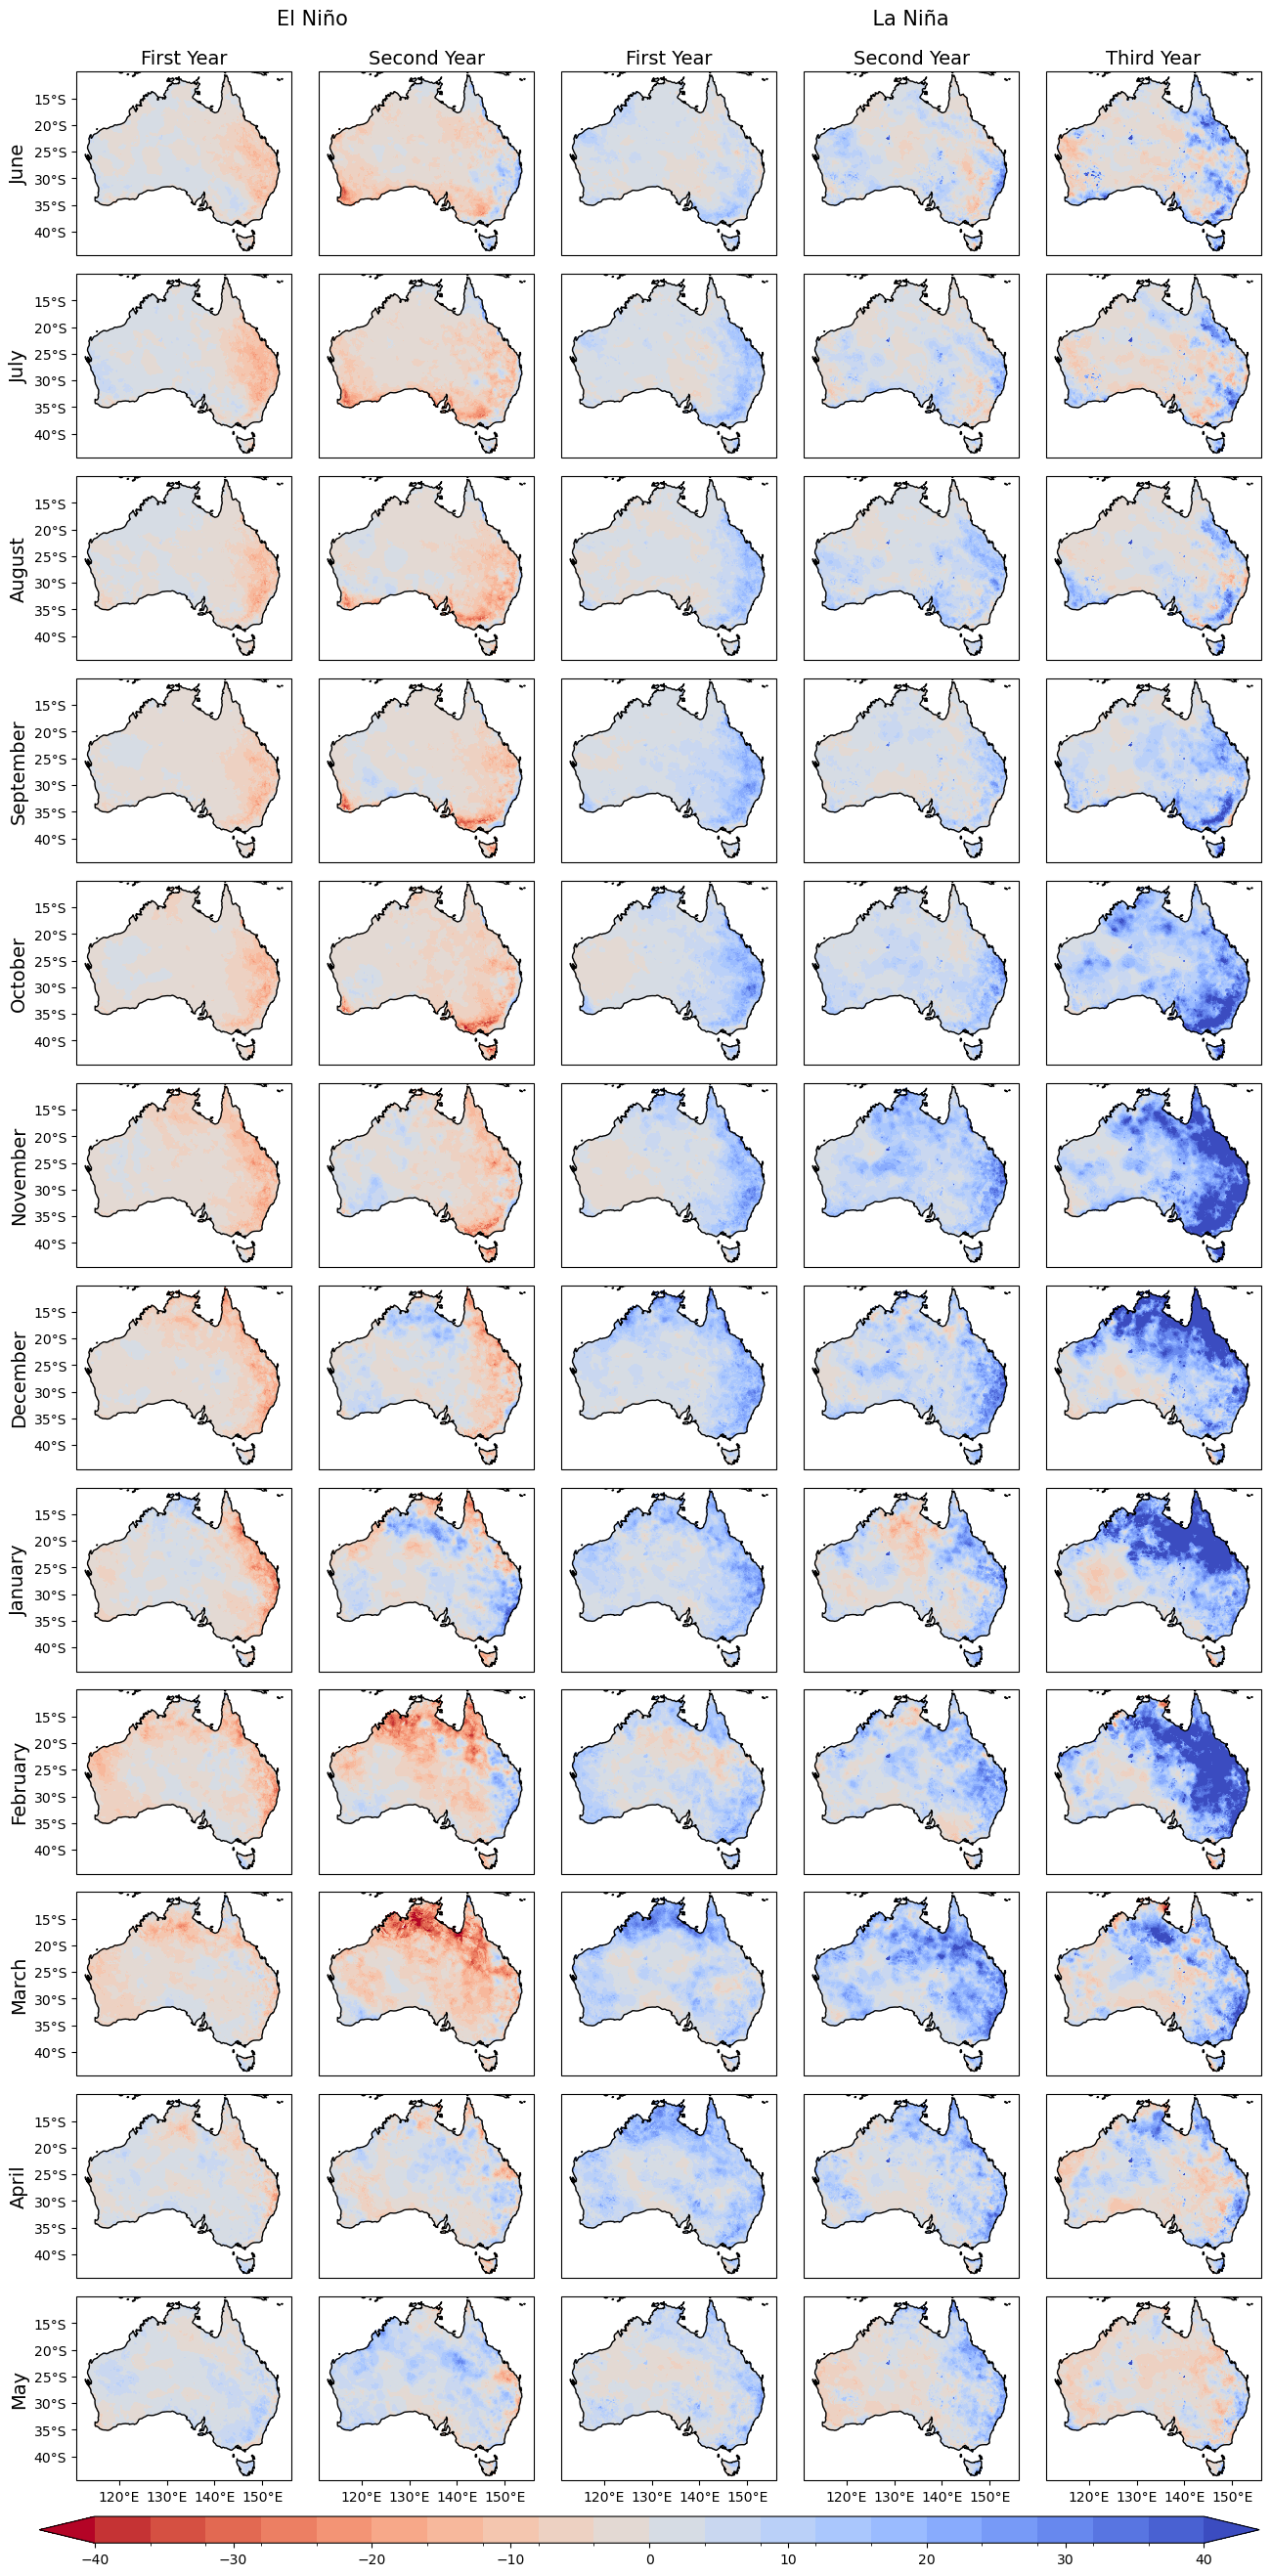

In [21]:
# pvalue = np.load('/g/data/w97/ah3693-2/CLEX_summer/FigS3_pvalue.npy',allow_pickle=True)
# all_mask = np.load('/g/data/w97/ah3693-2/CLEX_summer/FigS3_bootstrap_mask.npy',allow_pickle=True)
year_name = month_name[6:]+month_name[1:6]

fig, axes = plt.subplots(12,5, figsize=(16,32),subplot_kw=dict(projection=ccrs.PlateCarree()))

title = ['First Year','Second Year','First Year','Second Year','Third Year']

for i in range(5):    
    for j in range(12):
        ax=axes[j,i]
        if j <= 6:
            k = 0
        else:
            k = 1
            j = j - 7
        p = ENSO_fst_all[i][k][j].mean(dim='time').plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm_r',levels=np.linspace(-40,40,21),extend='both',add_colorbar=False)
        # ax.contourf(precip.lon, precip.lat, pvalue[i][k][j], levels = [0,0.05], hatches=['..'], colors='none', alpha=0.0)
        # ax.contourf(precip.lon, precip.lat, all_mask[i][k][j], levels = [0.99,1.01], hatches=['..'], colors='none', alpha=0.0)
        
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.coastlines()
        states.boundary.plot(ax=ax, color='black', linewidth=0.0)
        ax.set_extent([111,156.2, -44.5, -10.], crs=ccrs.PlateCarree())
        

for i in range(5):
    axes[0,i].set_title(title[i],fontsize=14)
    axes[11,i].set_xticks([120,130,140,150], crs=ccrs.PlateCarree())
    axes[11,i].set_xticklabels(['120°E','130°E','140°E','150°E'])
    axes[11,i].set_xlabel('')
for j in range(12):    
    axes[j,0].set_yticks([-40,-35,-30,-25,-20,-15], crs=ccrs.PlateCarree())
    axes[j,0].set_yticklabels(['40°S','35°S','30°S','25°S','20°S','15°S'])
    axes[j,0].set_ylabel(year_name[j],fontsize=14)

cax = plt.axes([0.11, 0.09, 0.78, 0.0085]) #[left, bottom, width, height]
plt.colorbar(p,cax=cax,orientation='horizontal')
cax.set_xticks([-40,-30,-20,-10,0,10,20,30,40])

# plt.text(-50.5,-34,'January                    December                  November',rotation=90,fontsize=14)
# plt.text(-47.9,39.4,'(a)                                    (d)                                    (g)                                    (j)                                     (m)',fontsize=14)
# plt.text(-47.9,10.4,'(b)                                    (e)                                    (h)                                    (k)                                    (n)',fontsize=14)
# plt.text(-48.07,-18.1,' (c)                                    (f)                                     (i)                                     (l)                                     (o)',fontsize=14)

# plt.text(-47.5,-40,'n = 29                              n = 9                                n = 23                              n = 11                              n = 5',fontsize=14)

plt.subplots_adjust(wspace=0,hspace=0.1)
plt.suptitle('El Niño                                                                                 La Niña',x=0.477,y=0.90,fontsize=15)

plt.savefig('/home/156/ah3693/CLEX_summer/FigR_Soil_Moisture_Anomaly_Composites.eps',bbox_inches="tight", format='eps',dpi=700)

plt.show()

## Other comment 1: How does other indices work? SOI.

Does SOI select the same double and triple events?

In [24]:
df = pd.read_csv("/g/data/w97/ah3693-2/CLEX_summer/soi_monthly.txt", header=None, names=["yearmonth", "SOI"]) #, sep=" ")

# separate year and month
df[['Year', 'Month']] = df['yearmonth'].astype(str).str.extract(r'(\d{4})(\d{2})')

# Drop the original 'yearmonth' column
df.drop('yearmonth', axis=1, inplace=True)

df['date'] = df['Year'] + '-' + df['Month'] + '-01'

# Converting the 'date' column to datetime format
df['time'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Setting the time column as the index
df.set_index('time', inplace=True)

In [25]:
soi_monthly = xr.DataArray(df['SOI'].values, dims=('time',), coords={'time': df.index})
soi_monthly.coords['month'] = ('time', df['Month'].astype('int64'))
soi_monthly = soi_monthly.sel(time=slice('1900','2023'))

In [26]:
# Same method with NOAA ONI, BOM has the SOI threshold at +/- 7
# Set the threshold value
threshold = 7.0

# Create a mask for values greater than the threshold
mask_EN = (soi_monthly >= threshold) 
mask_LN = (soi_monthly <= -threshold)

# Find the consecutive months with the threshold condition
consecutive_months_EN = mask_EN.rolling(time=3, min_periods=3).sum() >= 3
consecutive_months_LN = mask_LN.rolling(time=3, min_periods=3).sum() >= 3

# Select the months that meet both the threshold and consecutive months condition
selected_index_EN = soi_monthly.where(consecutive_months_EN).dropna(dim='time')
selected_index_LN = soi_monthly.where(consecutive_months_LN).dropna(dim='time')

elnino_y = selected_index_EN.sel(time = selected_index_EN.time.dt.month.isin([12]))
elnino_y2 = selected_index_EN.sel(time = selected_index_EN.time.dt.month.isin([1,2]))
lanina_y = selected_index_LN.sel(time = selected_index_LN.time.dt.month.isin([12]))
lanina_y2 = selected_index_LN.sel(time = selected_index_LN.time.dt.month.isin([1,2]))

elnino_year = np.sort(list(set(np.append(elnino_y.time.dt.year.values,elnino_y2.time.dt.year.values-1))))
lanina_year = np.sort(list(set(np.append(lanina_y.time.dt.year.values,lanina_y2.time.dt.year.values-1))))

print(elnino_year)
print(lanina_year)
print(len(elnino_year),len(lanina_year))

[1903 1910 1917 1921 1928 1938 1942 1950 1955 1961 1970 1973 1975 1988
 1998 1999 2000 2007 2008 2010 2011 2020 2022]
[1913 1918 1919 1925 1939 1940 1941 1963 1977 1982 1991 1994 1997 2009
 2015]
23 15


# Reviewer 2

## Major Comment 1: Too small sample size? Monte Carlo Significance Test.

Bootstrapping for Figure 4

In [27]:
dp_obs_new = xr.open_dataset('/g/data/w97/zg0866/ForAshley/AGCD/agcd_v2_precip_total_r005_monthly_1900-2023.nc').drop_duplicates('time')
fname = '/g/data/w97/zg0866/ForAshley/land_fixed_0.05.nc'
f = nc.Dataset(fname)
mask = f.variables['land'][:]
precip_masked = dp_obs_new.precip.where(mask==1)
precip = precip_masked
gb = precip.groupby('time.month')
precip_anom = gb - gb.mean(dim='time')

In [28]:
def ENSO_ndj(ENSO_year):
    
    precip_year1 = precip_anom.sel(time=precip_anom.time.dt.year.isin([ENSO_year]))
    precip_year2 = precip_anom.sel(time=precip_anom.time.dt.year.isin([np.asarray(ENSO_year) + 1]))
    precip_n = precip_year1.sel(time=precip_year1.time.month.isin([11]))
    precip_d = precip_year1.sel(time=precip_year1.time.month.isin([12]))
    precip_j = precip_year2.sel(time=precip_year2.time.month.isin([1]))
    
    return precip_n,precip_d,precip_j

ENSO_fst = [[],[],[],[],[],[]] # EN_f,EN_s,LN_f,LN_s,LN_t
for i,year in enumerate((fst_elnino_f,fst_elnino_s,fst_lanina_f,fst_lanina_s,fst_lanina_t)):
    ENSO_fst[i] = ENSO_ndj(year)

In [29]:
# All Nov, Dec, Jan
all_nov = precip_anom.sel(time=precip_anom.time.month.isin([11]))
all_dec = precip_anom.sel(time=precip_anom.time.month.isin([12]))
all_jan = precip_anom.sel(time=precip_anom.time.month.isin([1]))

In [30]:
# Use November and La Nina to do this
LN_nov_f = ENSO_fst[2][0]
LN_nov_s = ENSO_fst[3][0]
LN_nov_t = ENSO_fst[4][0]

In [31]:
def bootstrap_mask(bootstrap_repetitions, confidence_int, enso_n, all_month_file):
    sample_mean = [[] for _ in range(bootstrap_repetitions)]
    for i in range(bootstrap_repetitions):
        np.random.seed(i); sample = all_month_file.isel(time=np.random.randint(0, all_month_file.time.size, size = enso_n))
        sample_mean[i] = sample.mean(dim = 'time', skipna=True)
    sample_mean_all = xr.concat(sample_mean, dim='sample')

    def sort_3d(array):
        # Sorts a 2D numpy array
        return np.sort(array)
    
    # Apply sorting function along the 'lat' and 'lon' dimensions separately
    sorted_sample_props = xr.apply_ufunc(sort_3d, sample_mean_all, input_core_dims=[['sample']], output_core_dims=[['sample']])
    
    upper_threshold = sorted_sample_props.isel(sample = int(len(sorted_sample_props)*(confidence_int+((1-confidence_int)/2))))
    lower_threshold = sorted_sample_props.isel(sample = int(len(sorted_sample_props)*(1-confidence_int)/2))

    return upper_threshold, lower_threshold

def generate_mask(anomaly_file, upper_threshold, lower_threshold):
    monthly_anomaly_mean = anomaly_file.mean(dim='time')
    mask = ((monthly_anomaly_mean > upper_threshold) | (monthly_anomaly_mean < lower_threshold))
    return mask

In [32]:
# upper_nov = [[] for _ in range(5)]
# lower_nov = [[] for _ in range(5)]
# upper_dec = [[] for _ in range(5)]
# lower_dec = [[] for _ in range(5)]
# upper_jan = [[] for _ in range(5)]
# lower_jan = [[] for _ in range(5)]

# for i, n_list in enumerate([29, 9, 23, 11, 5]):
#     upper_nov[i], lower_nov[i] = bootstrap_mask(1000, 0.95, n_list, all_nov)
#     upper_dec[i], lower_dec[i] = bootstrap_mask(1000, 0.95, n_list, all_dec)
#     upper_jan[i], lower_jan[i] = bootstrap_mask(1000, 0.95, n_list, all_jan)

In [33]:
# nov_mask = [generate_mask(ENSO_fst[enso_order][0], upper_nov[enso_order], lower_nov[enso_order]) for enso_order in range(5)]
# dec_mask = [generate_mask(ENSO_fst[enso_order][1], upper_dec[enso_order], lower_dec[enso_order]) for enso_order in range(5)]
# jan_mask = [generate_mask(ENSO_fst[enso_order][2], upper_jan[enso_order], lower_jan[enso_order]) for enso_order in range(5)]

In [34]:
# significance_mask = [nov_mask, dec_mask, jan_mask]
# np.save('/g/data/w97/ah3693-2/CLEX_summer/Fig4_bootstrap_mask.npy', significance_mask)

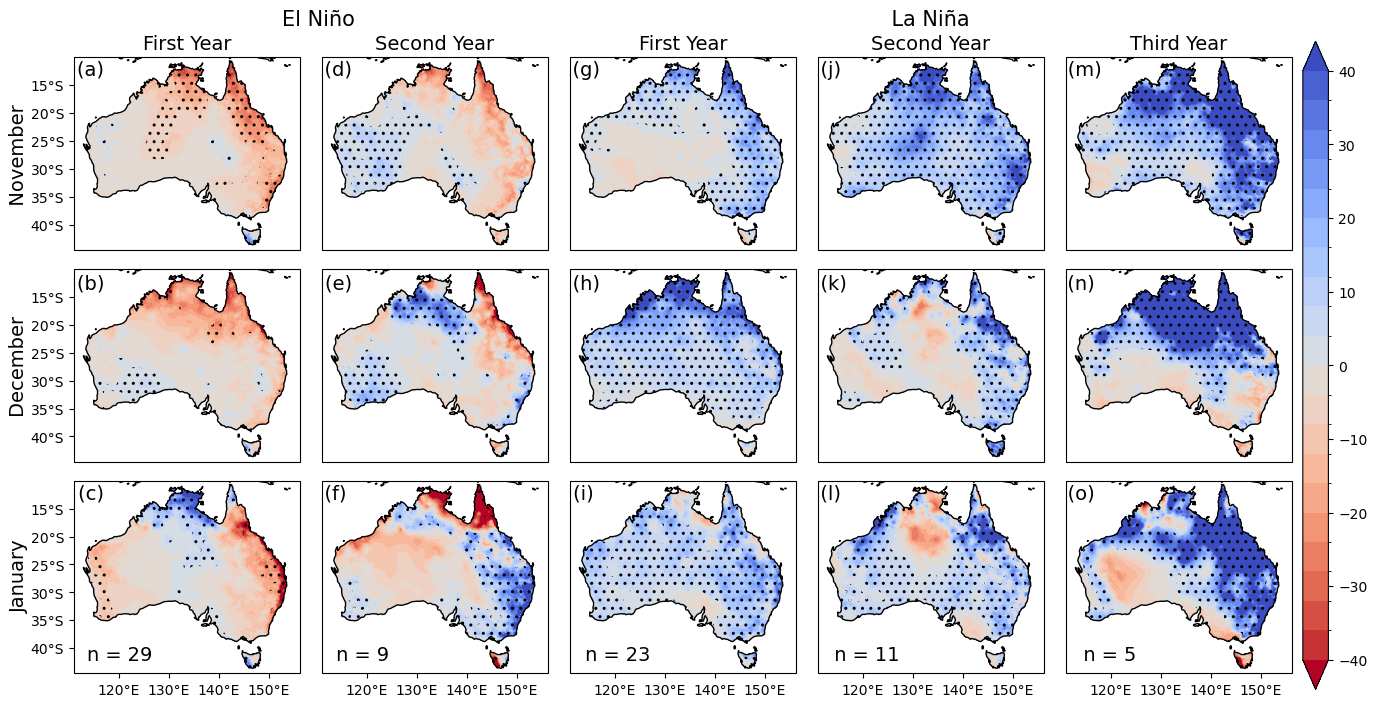

In [35]:
mask = np.load('/g/data/w97/ah3693-2/CLEX_summer/Fig4_bootstrap_mask.npy')

fig, axes = plt.subplots(3,5, figsize=(16,8),subplot_kw=dict(projection=ccrs.PlateCarree()))

title = ['First Year','Second Year','First Year','Second Year','Third Year']

for i in range(5):    
    for j in range(3):
        ax=axes[j,i]
        p = ENSO_fst[i][j].mean(dim='time').plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm_r',levels=np.linspace(-40,40,21),extend='both',add_colorbar=False)
        ax.contourf(precip.lon, precip.lat, mask[j][i], levels = [0.99,1.01], hatches=['..'], colors='none', alpha=0.0)
        
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.coastlines()
        states.boundary.plot(ax=ax, color='black', linewidth=0.0)
        ax.set_extent([111,156.2, -44.5, -10.], crs=ccrs.PlateCarree())
        

for i in range(5):
    axes[0,i].set_title(title[i],fontsize=14)
    axes[2,i].set_xticks([120,130,140,150], crs=ccrs.PlateCarree())
    axes[2,i].set_xticklabels(['120°E','130°E','140°E','150°E'])
    axes[2,i].set_xlabel('')
for j in range(3):    
    axes[j,0].set_yticks([-40,-35,-30,-25,-20,-15], crs=ccrs.PlateCarree())
    axes[j,0].set_yticklabels(['40°S','35°S','30°S','25°S','20°S','15°S'])
    axes[j,0].set_ylabel('')

cax = plt.axes([0.9, 0.09, 0.016, 0.81]) #[left, bottom, width, height]
plt.colorbar(p,cax=cax,orientation='vertical')
cax.set_yticks([-40,-30,-20,-10,0,10,20,30,40])

plt.text(-50.5,-33,'January                    December                  November',rotation=90,fontsize=14)
# plt.text(-45,70,'                     El Niño                                                                                       La Niña',rotation=0,fontsize=15)
# plt.text(-48,42,'(a)                                                        (d)                                                        (g)                                                       (j)                                                         (m)')
# plt.title(' (a)                                       (d)                                        (g)                                       (j)                                                     (m)',x=-47.9,y=1.01,fontsize=14,loc='left')
plt.text(-47.9,39.4,'(a)                                    (d)                                    (g)                                    (j)                                     (m)',fontsize=14)
plt.text(-47.9,10.4,'(b)                                    (e)                                    (h)                                    (k)                                    (n)',fontsize=14)
plt.text(-48.07,-18.1,' (c)                                    (f)                                     (i)                                     (l)                                     (o)',fontsize=14)

plt.text(-47.5,-40,'n = 29                              n = 9                                n = 23                              n = 11                              n = 5',fontsize=14)

plt.subplots_adjust(wspace=0,hspace=0.1)
plt.suptitle('El Niño                                                                                 La Niña',x=0.477,y=0.94,fontsize=15)

plt.savefig('/home/156/ah3693/CLEX_summer/Fig4_Summer_Rainfall_Anomalies.eps',bbox_inches="tight", format='eps',dpi=700)

plt.show()

## 3 months running mean of precipitation anomaly

In [ ]:
# 3 month average for SON, OND, NDJ, DJF

# son = 0, ond = 1, ndj = 2, djf = 3
def rolling_month_composites(climate_parameter,ENSO_year):

    seasonal_mean = climate_parameter.rolling(time=3,center=True).mean()
    
    parameter_year1 = seasonal_mean.sel(time=seasonal_mean.time.dt.year.isin([ENSO_year]))
    parameter_year2 = seasonal_mean.sel(time=seasonal_mean.time.dt.year.isin([np.asarray(ENSO_year) + 1]))
    
    son = parameter_year1.sel(time=parameter_year1.time.dt.month.isin([10]))
    ond = parameter_year1.sel(time=parameter_year1.time.dt.month.isin([11]))
    ndj = parameter_year1.sel(time=parameter_year1.time.dt.month.isin([12]))
    djf = parameter_year2.sel(time=parameter_year2.time.dt.month.isin([1]))
    
    return [son, ond, ndj, djf]

In [ ]:
precip_rolling_elnino_year1, precip_rolling_elnino_year2 = [rolling_month_composites(precip_anom, elnino_fst) for elnino_fst in [fst_elnino_f, fst_elnino_s]]
precip_rolling_lanina_year1, precip_rolling_lanina_year2, precip_rolling_lanina_year3 = [rolling_month_composites(precip_anom, elnino_fst) for elnino_fst in [fst_lanina_f, fst_lanina_s, fst_lanina_t]]

In [ ]:
sublabel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)','(n)','(o)','(p)','(q)','(r)','(s)','(t)','(u)','(v)','(w)','(x)']

In [ ]:
# pvalue = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]

# precip_rolling = [precip_rolling_elnino_year1, precip_rolling_elnino_year2, precip_rolling_lanina_year1, precip_rolling_lanina_year2, precip_rolling_lanina_year3]

# for i in range(5):
#     for j in range(4):
#         pvalue[i][j] = stats.ttest_1samp(precip_rolling[i][j],0,axis=0)[1]
        
# np.save('/g/data/w97/ah3693-2/CLEX_summer/Fig4_pvalue.npy', pvalue)

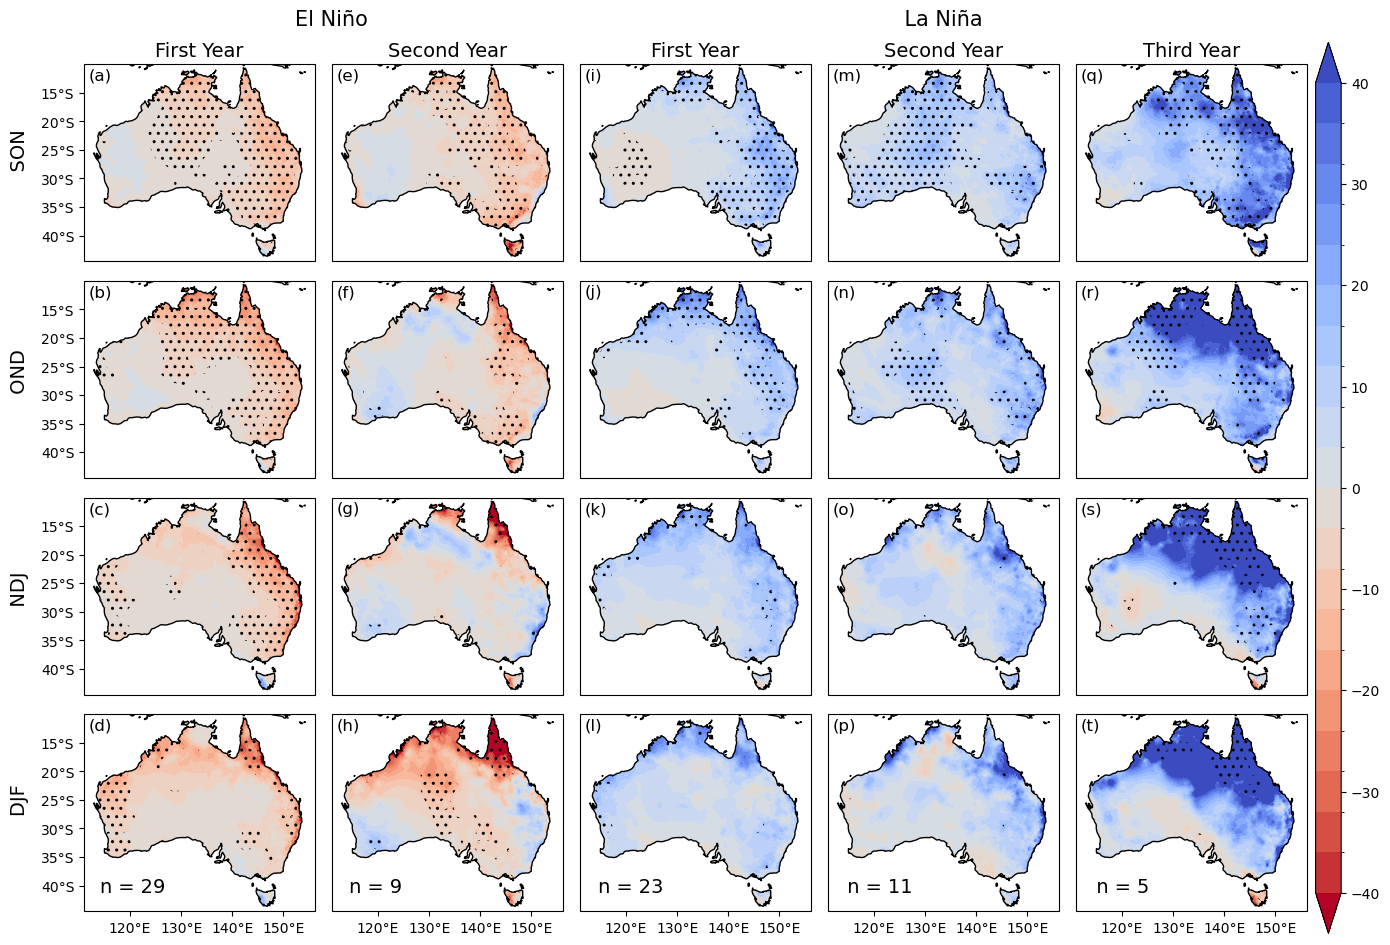

In [ ]:
pvalue_fig4 = np.load('/g/data/w97/ah3693-2/CLEX_summer/Fig4_pvalue.npy')

fig, axes = plt.subplots(4,5, figsize=(16, 11),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
title = ['First Year','Second Year','First Year','Second Year','Third Year']

for i, ENSO_fst in enumerate([precip_rolling_elnino_year1, precip_rolling_elnino_year2, precip_rolling_lanina_year1, precip_rolling_lanina_year2, precip_rolling_lanina_year3]):    
    for j in range(4):
        ax=axes[j,i]
        ax.annotate(sublabel[4*i+j], xy=(0.02, 0.92), xycoords='axes fraction', fontsize=12)
        p = ENSO_fst[j].mean(dim='time').plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm_r',levels=np.linspace(-40,40,21),extend='both',add_colorbar=False)
        ax.contourf(precip.lon - 180, precip.lat, pvalue_fig4[i][j], levels = [0,0.05], hatches=['..'], colors='none', alpha=0.0)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.coastlines()
        states.boundary.plot(ax=ax, color='black', linewidth=0.0)
        ax.set_extent([111,156.2, -44.5, -10.], crs=ccrs.PlateCarree())

for i in range(5):
    axes[0,i].set_title(title[i],fontsize=14)
    axes[3,i].set_xticks([120,130,140,150], crs=ccrs.PlateCarree())
    axes[3,i].set_xticklabels(['120°E','130°E','140°E','150°E'])
    axes[3,i].set_xlabel('')
for j in range(4):    
    axes[j,0].set_yticks([-40,-35,-30,-25,-20,-15], crs=ccrs.PlateCarree())
    axes[j,0].set_yticklabels(['40°S','35°S','30°S','25°S','20°S','15°S'])
    axes[j,0].set_ylabel('')

cax = plt.axes([0.9, 0.09, 0.016, 0.81]) #[left, bottom, width, height]
plt.colorbar(p,cax=cax,orientation='vertical')
cax.set_yticks(np.linspace(-40,40,9))

plt.text(-51,-32,'DJF                             NDJ                             OND                             SON',rotation=90,fontsize=14)
plt.text(-47.5,-40,'n = 29                              n = 9                                n = 23                              n = 11                              n = 5',fontsize=14)

plt.subplots_adjust(wspace=0,hspace=0.1)
plt.suptitle('El Niño                                                                                 La Niña',x=0.477,y=0.93,fontsize=15)

plt.savefig('/home/156/ah3693/CLEX_summer/Fig4_R6_New_Summer_Rainfall_Anomalies.eps',bbox_inches="tight", format='eps',dpi=700)

plt.show()